In [1]:
import sys
import pandas as pd
from tqdm.notebook import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification, TextClassificationPipeline, pipeline

In [2]:
print('Loading language classifier model...')
model_name = 'qanastek/51-languages-classifier'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

print('Loading question answering model trained on XQUAD...')
model_name2 = 'salti/bert-base-multilingual-cased-finetuned-squad'
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForQuestionAnswering.from_pretrained("salti/bert-base-multilingual-cased-finetuned-squad")
qa = pipeline('question-answering', model=model2, tokenizer=tokenizer2)

Loading language classifier model...
Loading question answering model trained on XQUAD...


In [3]:
# open txt file from command line argument adn  save as dataframe
def open_txt_file(file_path):
    with open(file_path, "r",encoding= 'utf-8' ) as f:
        data = f.readlines()
    df = pd.DataFrame(data, columns=['text'])
    df = df.apply(lambda x: x.str.replace("\n",""))
    return df

df = open_txt_file('input_tp4.txt')

In [4]:
xsquad_unique = ['ar' ,'de', 'el', 'en', 'es', 'hi', 'ru', 'ro']
xcopa_unique = ['et','ht','id','it','qu','sw','ta']
common = ['th', 'tr', 'vi' ,'zh']

In [54]:
languages = xsquad_unique + xcopa_unique + common
languages.__len__()

19

In [5]:
# add columns language and dataset to df
df['language'] = ''
df['dataset'] = ''

In [6]:
df

text language dataset
0     அந்த ஓவியக் கலைஞர் மஞ்சள் நிற பெயிண்ட்டுடன் நீ...                 
1                           Ta raiskas oma varanduse.\n                 
2                       กลุ่มหัวรุนแรงมีอิทธิพลต่อเขา\n                 
3                                 Il padre lo sgridò.\n                 
4     อย่างไรก็ดี ทัศนคติทางด้านศาสนาของเทสลายังคงเป...                 
...                                                 ...      ...     ...
5995           Gli ho chiesto di abbassare il volume.\n                 
5996                                  Trovai un'arma.\n                 
5997                       அந்த வீடு காலியாக இருந்தது\n                 
5998                                         他们输掉了比赛。\n                 
5999         La donna stabilì un obiettivo ambizioso.\n                 

[6000 rows x 3 columns]

In [11]:
MAX_TOKEN_LENGTH = 512

# for sentence in df['text']:
for i in tqdm(range(len(df))): 
    
    text = df['text'][i]
    if len(text) > MAX_TOKEN_LENGTH:
        text = text[:MAX_TOKEN_LENGTH]

    res = classifier(text)[-1]['label'][:2]
    
    if res in xsquad_unique:
        df['dataset'][i] = 'xquad'
        df['language'][i] = res
    elif res in xcopa_unique:
        df['dataset'][i] = 'xcopa'
        df['language'][i] = res
    elif res in common:
        df['dataset'][i] = 'common'
        df['language'][i] = res
    else:
        df['dataset'][i] = 'other'
        df['language'][i] = res

df.to_csv('output_tp4.txt', index=False, sep='\t')

  0%|          | 0/6000 [00:00<?, ?it/s]

### Handle "other" category for missclassified languages

In [121]:
import numpy as np
idx = np.where(df['dataset'] == 'other')[0]

for i in tqdm(idx):
    text = df['text'][i]
    if len(text) > MAX_TOKEN_LENGTH:
        text = text[:MAX_TOKEN_LENGTH]
    res = classifier(text)[0]

    scores = pd.DataFrame(res).sort_values(by='score', ascending=False)
    scores['label'] = scores['label'].apply(lambda x : x[:2])
    language = scores[scores['label'].isin(languages)].head(1)['label'].values[0]

    if language == 'fi': language = 'et'
    if language == 'ms': language = 'id'
    if language == 'cy':
        if 'Mwen' in text: language = 'ht'
        else: language = 'qu'

    df['language'][i] = language
    
    if language in xsquad_unique:
        df['dataset'][i] = 'xquad'
    elif language in xcopa_unique:
        df['dataset'][i] = 'xcopa'
    elif language in common:
        df['dataset'][i] = 'common'

df.to_csv('output_tp4.txt', index=False, sep='\t')

  0%|          | 0/1148 [00:00<?, ?it/s]

<AxesSubplot:xlabel='language'>

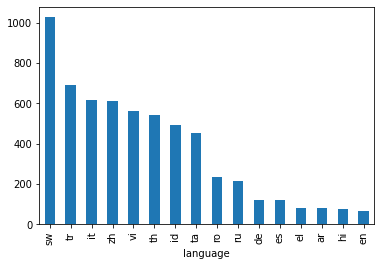

In [132]:
df.value_counts('language').plot(kind='bar')

<AxesSubplot:xlabel='dataset'>

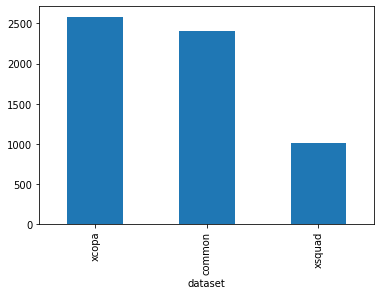

In [133]:
df.value_counts('dataset').plot(kind='bar')

In [ ]:
# How we reclassified the 'other' dataset

# fi --> et
# ms --> id
# cy, sq --> qu, ht
# ar --? reclassify (tr/ru )
# jv --? reclassify (ht, sw, id)

### Handle "Common" dataset category

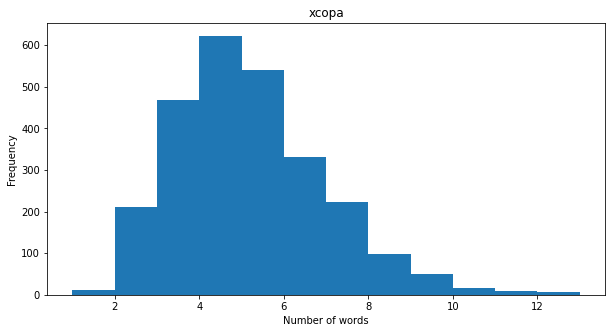

Text(0.5, 0, 'Number of words')

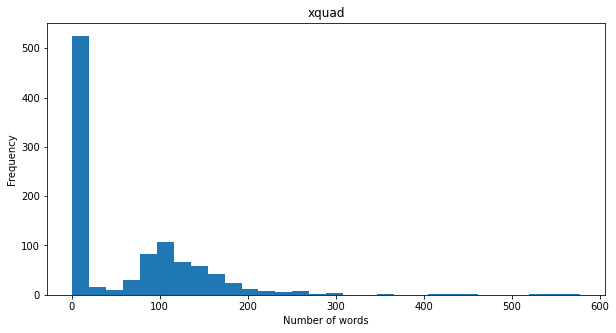

In [169]:
import matplotlib.pyplot as plt

df_xcopa = df[df['dataset'] == 'xcopa']
lens = df_xcopa['text'].apply(lambda x: len(x.split(' ')))
lens.plot(kind='hist', bins=12, title='xcopa', figsize=(10,5))
plt.xlabel('Number of words')
plt.show()
df_xquad = df[df['dataset'] == 'xquad']
lens_ = df_xquad['text'].apply(lambda x: len(x.split(' ')))
lens_.plot(kind='hist', bins=30, title='xquad', figsize=(10,5))
plt.xlabel('Number of words')

<AxesSubplot:title={'center':'xquad < 15 words'}, ylabel='Frequency'>

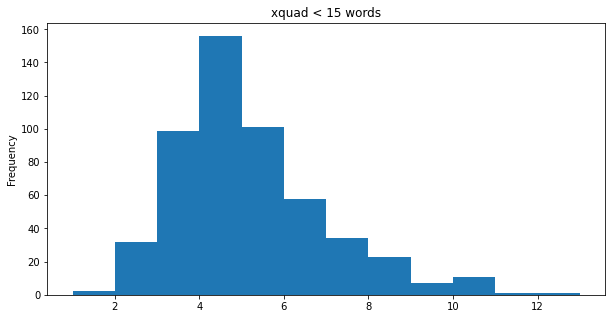

In [190]:
lens_[lens_<15].plot(kind='hist', bins=12, title='xquad < 15 words', figsize=(10,5))


<AxesSubplot:title={'center':'xquad > 40 words'}, ylabel='Frequency'>

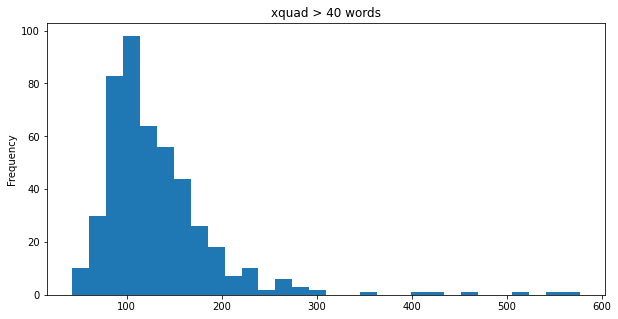

In [191]:
lens_[lens_>40].plot(kind='hist', bins=30, title='xquad > 40 words', figsize=(10,5))


### Identify missclassifications for XQUAD where text is too short

<AxesSubplot:title={'center':'xquad < 15 words'}, xlabel='language'>

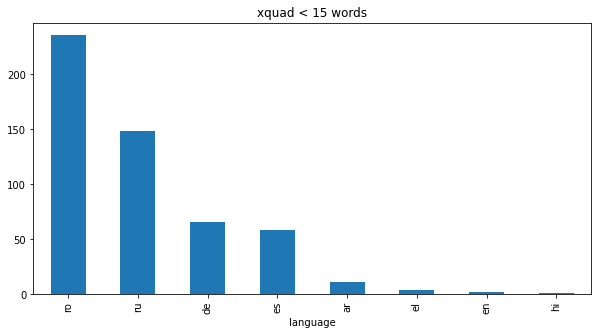

In [182]:
df_xquad[lens_ < 15].value_counts('language').plot(kind='bar', title='xquad < 15 words', figsize=(10,5))

In [184]:
print(xcopa_unique)
print(xsquad_unique)

['et', 'ht', 'id', 'it', 'qu', 'sw', 'ta']
['ar', 'de', 'el', 'en', 'es', 'hi', 'ru', 'ro']


In [189]:
df_xquad.where(df_xquad[lens_ < 15]['language']=='ro').dropna()

text language dataset
1                           Ta raiskas oma varanduse.       ro  xsquad
25                           Ta kustutas oma vastuse.       ro  xsquad
33                  Ma thatsin keelaaega kontrollida.       ro  xsquad
45    Ma panin paberrätiku mahaläinud vedeliku peale.       ro  xsquad
60                          Sõbrad kaotasid ühenduse.       ro  xsquad
...                                               ...      ...     ...
5820                                Fou a te vin cho.       ro  xsquad
5845                             Ma tegin ümbersõidu.       ro  xsquad
5951                 Yo te evite diskite pwoblem nan.       ro  xsquad
5978                      Ta lendas tagasi üles õhku.       ro  xsquad
5992                         Li t ap pale poukont li.       ro  xsquad

[235 rows x 3 columns]

### Conclusion:

These observations confirm our hypothesis that XCOPA is distributed around small texts (~5 words), whereas the XQUAD lines come only from contexts of the XQUAD dataset, and not questions or answers which are shorter.

<AxesSubplot:title={'center':'Text lengths'}, ylabel='Frequency'>

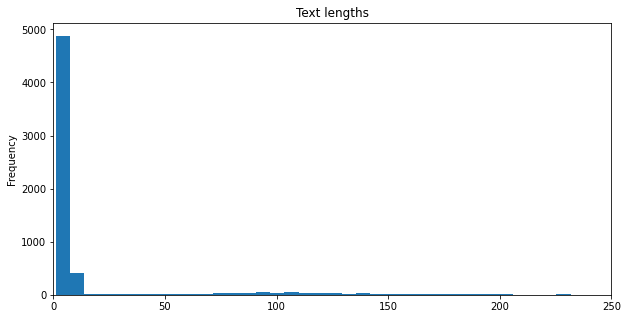

In [205]:
lengths = df['text'].apply(lambda x: len(x.split(' ')))
lengths.plot(kind='hist', bins=100, title='Text lengths', figsize=(10,5), xlim=(0,250))

#### Fix XQUAD missclassifications

In [207]:
THRESHOLD = 15

idx = np.where(df['dataset'] == 'xquad')[0]

for i in tqdm(idx):
    if df['text'][i].split().__len__() < THRESHOLD:
        df['dataset'][i] = 'xcopa'
    

  0%|          | 0/1006 [00:00<?, ?it/s]

#### Reclassify common category

In [212]:
idx = np.where(df['dataset'] == 'common')[0]

for i in tqdm(idx):
    if df['text'][i].split().__len__() < THRESHOLD:
        df['dataset'][i] = 'xcopa'
    else:
        df['dataset'][i] = 'xquad'

0it [00:00, ?it/s]

<AxesSubplot:>

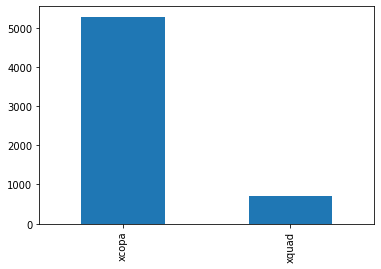

In [218]:
df['dataset'].value_counts().plot(kind='bar')

In [221]:
df.to_csv('output_tp4.txt', index=False, sep='\t')

<AxesSubplot:>

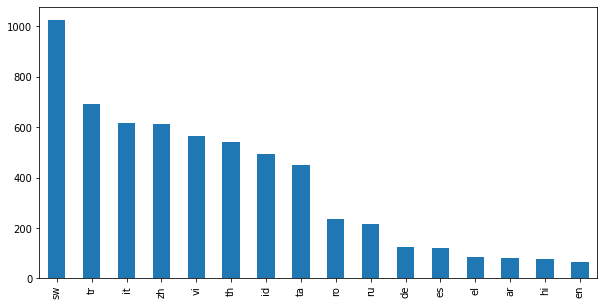

In [220]:
df['language'].value_counts().plot(kind='bar', figsize=(10,5))